# Figure 6 (Appendix)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import torch

sys.path.insert(0, '../')

from src.dataset import get_num_classes, load_dataset
from src.models import init_model

In [3]:
dataset_size = 0
dataset_name = 'cifar10'
architecture = 'cnn-large'
num_classes = get_num_classes(dataset_name)

dataset = load_dataset(dataset=dataset_name, transform='normalize', dataset_size=dataset_size, seed=42, path='../data')
train_and_test = dataset['train_and_test']

Files already downloaded and verified


Label 0


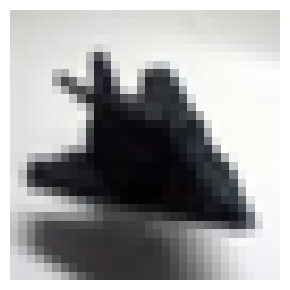

In [4]:
tidx = 29
target_record, label = train_and_test[tidx]
print('Label', label)

def imshow(img):
    plt.subplots(figsize=(3, 3))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.tight_layout()
    plt.savefig('plots/airplane.pdf')
    plt.show()
    plt.close()

imshow(target_record)

In [5]:
@torch.no_grad()
def get_activation_maps(model, image, layer=1):
    C, D1, D2 = image.size()
    output1 = model.conv1(image.view(1, C, D1, D2))
    if layer == 1:
        return output1.squeeze(0)
    elif layer == 2:
        output2 = model.conv2(output1).view(50, 5, 5)
        return output2
    else:
        raise ValueError(f'ERROR: Invalid layer {layer}.')

## Figure 6 - Varying the dataset size

In [6]:
experiments_dir = f'../experiments/{dataset_name}/controlled_randomness/{architecture}/dsize-50000'
print('Experiments path', experiments_dir)
num_experiments = 6
dataset_sizes = [1250, 2500, 6250, 12500, 25000, 50000]

Experiments path ../experiments/cifar10/controlled_randomness/cnn-large/dsize-50000


_Note:_ It takes a few seconds to load the models.

In [7]:
print('Loading the models')
models = dict({'dataset_sizes': []})
test_accs = dict({'dataset_sizes': []})
for key in models:
    models_dir = os.path.join(experiments_dir, key)
    for exp in range(num_experiments)[::-1]:
        models_path = os.path.join(models_dir, f'exp_{exp}_model.pickle')
        if not os.path.exists(models_path):
            continue
        with open(models_path, 'rb') as f:
            saved_model = pickle.load(f)
        model = init_model(architecture, num_classes, verbose=False)
        model.load_state_dict(saved_model['model_state_dict'])
        model.eval()
        models[key].append(model)
        test_accs[key].append(saved_model['test_acc'])
    print(f'Found {len(models[key])} models for the {key} experiment.')

Loading the models
Found 6 models for the dataset_sizes experiment.


_Note:_ It takes a few seconds to generate the visualisations.

Varying the dataset_sizes source of randomness.
Layer 1
Model 0 (dataset size = 1250). Test accuracy=43.9%
Model 1 (dataset size = 2500). Test accuracy=49.0%
Model 2 (dataset size = 6250). Test accuracy=58.2%
Model 3 (dataset size = 12500). Test accuracy=64.7%
Model 4 (dataset size = 25000). Test accuracy=71.8%
Model 5 (dataset size = 50000). Test accuracy=76.8%


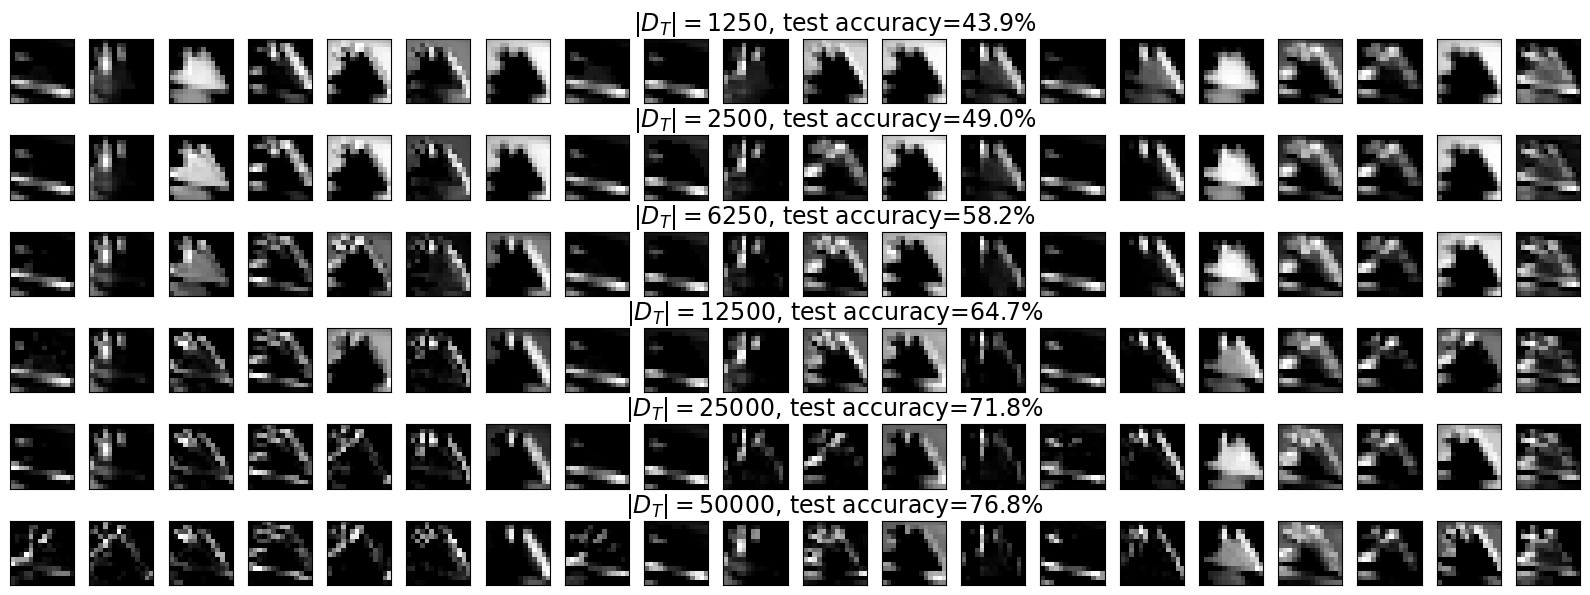

In [8]:
layer = 1
for key in models:
    print(f'Varying the {key} source of randomness.')
    print(f'Layer {layer}')
    fig, axes = plt.subplots(6, 20, figsize=(16, 6))
    for exp in range(len(models[key])):
        maps = get_activation_maps(models[key][exp], target_record, layer=layer)
        layer_viz = maps.data
        print(f'Model {exp} (dataset size = {dataset_sizes[exp]}). Test accuracy={test_accs[key][exp]:.1%}')
        for i, filter in enumerate(layer_viz):
            if i == layer_viz.size(0): 
                break
            axes[exp][i].imshow((filter-filter.min())/(filter.max()-filter.min()), vmin=0, vmax=1, cmap='gray')
            axes[exp][i].tick_params(
                axis='both',
                which='both',# both major and minor ticks are affected
                bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
            axes[exp][10].set_title(r'$|D_T|=$'+f'{dataset_sizes[exp]}, test accuracy={test_accs[key][exp]:.1%}', fontsize=17)
    plt.tight_layout()
    plt.savefig(f'plots/{key}_50000_0.01.pdf', bbox_inches='tight')
    plt.show()
    plt.close()